In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import json

### Create Dataset from JSON File

In [2]:
class TrajectoryDataset(Dataset):

    def __init__(self, json_file):

        with open(json_file, 'r') as f:
            self.data_dict = json.load(f)
        
        self.data = self.data_dict['data']
        
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        item = self.data[idx]
        
        goal = np.array([
            item['config']['goal']['x'],
            item['config']['goal']['y'],
            item['config']['goal']['z']
        ])
        
        config = goal # Label, Shape (3, )
        
        waypoints = []
        for wp in item['trajectory']['waypoints']:
            waypoints.append([
                wp['x'], wp['y'], wp['z'],
                wp['qx'], wp['qy'], wp['qz'], wp['qw']
            ])
        trajectory = np.array(waypoints)  # Output Data, Shape: (seq_len, 7)
        
        return torch.FloatTensor(config), torch.FloatTensor(trajectory)
    

from torch.nn.utils.rnn import pad_sequence
def collate_pad(batch):
    xs, ys = zip(*batch)                 # tuples
    xs = torch.stack(xs, dim=0)          # [B, 3]

    
    lengths = torch.tensor([y.size(0) for y in ys], dtype=torch.long)
    ys = pad_sequence(ys, batch_first=True) 

    B, T_max, _ = ys.shape

    eos = torch.zeros(B, T_max, dtype=torch.float32)
    eos_mask = torch.zeros(B, T_max, dtype=torch.bool)

    for b, L in enumerate(lengths):
        eos[b, L-1] = 1.0
        eos_mask[b, :L] = True

    return xs, ys, lengths, eos, eos_mask  

### Model Architecture

In [3]:
class mlp_encoder(nn.Module):
    
    def __init__(self, config_size, hidden_size, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        
        # Define the MLP using nn.Sequential
        self.mlp = nn.Sequential(
            nn.Linear(config_size, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )
        
    def forward(self, config):
        # config: (batch_size, config_size)
        hidden = self.mlp(config)
        
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1) # Size (num_layers=2, batch_size, hidden_size=128)

        return hidden, hidden  # Return as (h_0, c_0) for LSTM
        # c_0: long-term memory
        # h_0: short-term memory



class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''
        
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)   

        self.eos_head = nn.Linear(hidden_size, 1)
        nn.init.constant_(self.eos_head.bias, -2.0)  

    def forward(self, x_input, encoder_hidden_states):
        
        '''        
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence 
 
        '''
        
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states) 


        state_output = self.linear(lstm_out.squeeze(0))   # Shape (batch_size, 7) 
        eos = self.eos_head(lstm_out.squeeze(0)) # Shape (batch_size, 1)
        
        return state_output, eos, self.hidden

### Helper Functions for Evaluating Model Performance

In [4]:
@torch.no_grad()
def rollout_until_eos(decoder, decoder_input, decoder_hidden, 
                      eos_thresh=0.5, max_steps=512, 
                      device='cuda' if torch.cuda.is_available() else 'cpu'):
    B, _ = decoder_input.shape

    pred_len = torch.zeros(B, dtype=torch.long, device=device) # Size (B ,)

    predicted = []
    predicted_eos = []

    for t in range(max_steps):

        decoder_output, decoder_eos, decoder_hidden = decoder(decoder_input, decoder_hidden)
        predicted.append(decoder_output) # decoder_output shape: (B, 7)
        predicted_eos.append(decoder_eos.squeeze(-1))

        stop_prob = torch.sigmoid(decoder_eos).squeeze(-1) # (B, ) tensor of probabilities that the trajectory at some index has reached its end. 
        finished_idx = (stop_prob > eos_thresh) & (pred_len == 0) # (B ,) tensor of booleans that indicate if a trajectory has reached EOS and it hasn't already ended before. 

        pred_len[finished_idx] = t + 1

        if (pred_len > 0).all():
            break

        decoder_input = decoder_output


    T_gen = len(predicted)
    pred_len = torch.where(pred_len == 0, torch.full_like(pred_len, T_gen), pred_len)

    predicted = torch.stack(predicted, dim = 1) # (B, T_gen, 7)
    predicted_eos = torch.stack(predicted_eos, dim = 1) # (B, T_gen)
    
    return predicted, predicted_eos, pred_len


import torch.nn.functional as F
@torch.no_grad()
def calculate_loss_for_rollout_until_eos(pred, gt, pred_len, gt_len, B, eos_logits, eos_gt):

    state_loss_fcn = nn.MSELoss()

    # pred: (B, T_gen, 7)  --> Predicted Trajectories
    # gt: (B, seq_len, 7)  --> Ground Truth Trajectories
    # eos_logits: (B, T_gen)
    # eos_gt: (B, seq_len)
    # pred_len: (B, )
    # gt_len: (B, 

    traj_losses = []
    eos_losses = []
    
    for b in range(B):

        T = int(min(pred_len[b].item(), gt_len[b].item()))

        pred_traj = pred[b, :T, :] 
        gt_traj = gt[b, :T, :] 

        traj_loss = state_loss_fcn(pred_traj, gt_traj)
        traj_losses.append(traj_loss)

        pred_eos = eos_logits[b, :T]
        eos_target = eos_gt[b, :T].float()

        # Get the loss between pred_eos and gt_eos

        # Optional: balance the one-positive-per-seq imbalance
        pos = eos_target.sum()                                # number of 1s (0 or 1 here)
        neg = torch.tensor(T, device=pred_eos.device, dtype=pred_eos.dtype) - pos
        pos_weight = (neg / pos).clamp_min(1.0) if pos > 0 else torch.tensor(1.0, device=pred_eos.device, dtype=pred_eos.dtype)

        eos_loss = F.binary_cross_entropy_with_logits(pred_eos, eos_target, pos_weight=pos_weight)

        eos_losses.append(eos_loss)


    traj_mean = torch.stack(traj_losses).mean()
    eos_mean = torch.stack(eos_losses).mean()

    return traj_mean + 0.2*eos_mean, traj_mean, eos_mean

### Function for Training

In [5]:
import torch.nn.functional as F
def train(encoder, decoder, train_loader, val_loader, 
          epochs, learning_rate, tf_ratio, dynamic_tf, 
          device='cuda' if torch.cuda.is_available() else 'cpu'):
    
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = optim.Adam(params, lr=learning_rate)

    loss_function = nn.MSELoss(reduction='none')
    # EOS Loss Function
    eos_loss_fcn = nn.BCEWithLogitsLoss(reduction='none')

    history = {
        'train_loss': [],
        'val_loss': [],
        'teacher_forcing_ratio': []
    }

    for epoch in range(epochs):

        encoder.train()
        decoder.train()
        training_loss = 0.0

        for b, data in enumerate(train_loader):
            
            config = data[0].to(device) # (batch_size, 3)
            traj = data[1].to(device)
            lengths = data[2].to(device)
            eos_ground_truth = data[3].to(device).float() # (batch_size, max_seq_len)
            mask = data[4].to(device) # (batch_size, max_seq_len)

            traj = traj.transpose(0, 1) # (batch_size, max_seq_len, 7) --> (max_seq_len, batch_size, 7)
            ts = traj.shape[0]
            batch_size = traj.shape[1]
    
            optimizer.zero_grad()

            hidden = encoder(config)

            decoder_input = torch.zeros(batch_size, 7).to(device) # (batch_size, 7) 
            decoder_hidden = hidden

            predictions = torch.zeros(ts, batch_size, 7).to(device) # (max_seq_len, batch_size, 7)
            eos_logits = torch.zeros(ts, batch_size).to(device) # (max_seq_len, batch_size)

            use_tf = np.random.random() < tf_ratio

            for t in range(ts):

                decoder_output, decoder_eos, decoder_hidden = decoder(decoder_input, decoder_hidden)
                # decoder_output size: (batch_size, 7)
                # decoder_hidden size: tuple ((num_layers=2, batch_size, hidden_size=128), (num_layers=2, batch_size, hidden_size=128))

                predictions[t] = decoder_output
                eos_logits[t] = decoder_eos.squeeze(-1)
                
                if t < ts - 1:
                    if use_tf:
                        tf_ok = (t < (lengths - 1)).float().unsqueeze(-1) # (B,1) tensor of 1s or 0s, 
                        next_tf = traj[t]
                        decoder_input = tf_ok * next_tf + (1 - tf_ok) * decoder_output
                    else:
                        decoder_input = decoder_output


            ## --- Loss From the State Prediction --- #
            per_elem = loss_function(predictions, traj) # (max_seq_len, batch_size, 7)
            per_step = per_elem.mean(-1) # (max_seq_len, batch_size)
            # Meaning: 
            # Consider per_step[0][0]
            # This means that this is the mean of the squared loss between the prediction's and ground truth's (x,y,z,qx,qy,qz,qw), 
            # for the first trajectory in the batch, and at the very first timestep
            state_loss = ((per_step * mask.transpose(0,1)).sum()) / mask.sum().clamp_min(1)
            # mask has size (batch_size, max_seq_len)
            # Doing an element-wise multiplication between mask and per_step ensures that the loss values from padded inputs don't affect
            # the actual loss calculation

            ## --- Loss From the EOS Prediction --- #
            # Note: Needs positive weight.

            pos = eos_ground_truth[mask.bool()].sum()                       # number of 1s
            neg = mask.sum() - pos
            pos_weight = (neg / pos).clamp_min(1.0).to(device) if pos > 0 else torch.tensor(1.0, device=device)

            eos_loss_per_step = F.binary_cross_entropy_with_logits(
                eos_logits.transpose(0,1),          # (B,T)
                eos_ground_truth,                   # (B,T)
                reduction='none',
                pos_weight=pos_weight
            )
            eos_loss = (eos_loss_per_step * mask).sum() / mask.sum().clamp_min(1)


            loss = state_loss + 0.2*eos_loss

            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        avg_train_loss = training_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['teacher_forcing_ratio'].append(tf_ratio)


        if val_loader is not None:

            encoder.eval()
            decoder.eval()
            val_loss = 0.0

            with torch.no_grad():

                for data in val_loader:


                    config = data[0].to(device) # (batch_size, 3)
                    traj_gt = data[1].to(device)
                    lengths_gt = data[2].to(device)
                    eos_gt = data[3].to(device).float() # (batch_size, max_seq_len)

                    batch_size = config.size(0)
                    decoder_hidden = encoder(config)
                    decoder_input = torch.zeros(batch_size, 7).to(device)

                    pred, pred_eos, pred_lens = rollout_until_eos(decoder=decoder, decoder_input=decoder_input, decoder_hidden=decoder_hidden)
                    val_loss_batch, _, _ = calculate_loss_for_rollout_until_eos(pred=pred, gt=traj_gt, 
                                                                          pred_len=pred_lens, gt_len=lengths_gt, 
                                                                          B=batch_size, eos_logits=pred_eos, eos_gt=eos_gt)
                    val_loss += val_loss_batch.item()

            avg_val_loss = val_loss / len(val_loader)
            history['val_loss'].append(avg_val_loss)

            print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}')
        else:
            print(f'Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}')

        if dynamic_tf and tf_ratio > 0:
            tf_ratio = max(0, tf_ratio - (1.0 / epochs))

    
    return history

### Initialize Dataloaders and Train the Model

In [6]:
dataset = TrajectoryDataset('datasets/trajectory_dataset_1.json')

N = len(dataset)
train_size = int(0.8 * N)
val_size = int(0.1 * N)
test_size  = N - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
)

train_dataloader = DataLoader(
    train_dataset,  
    batch_size=32,
    collate_fn=collate_pad,
    shuffle=True,
    num_workers=0  
)
        
val_dataloader = DataLoader(
    val_dataset, 
    batch_size=10,
    collate_fn=collate_pad,
    shuffle=False,
    num_workers=0
)

encoder = mlp_encoder(config_size=3, hidden_size=128, num_layers=2)
decoder = lstm_decoder(input_size=7, hidden_size=128, num_layers=2)  

EPOCHS = 100
history = train(encoder=encoder,
                decoder=decoder,
                train_loader=train_dataloader,
                val_loader=val_dataloader,
                epochs=EPOCHS,
                learning_rate=0.001,
                tf_ratio=1.0,
                dynamic_tf=True)

Epoch 1: Train Loss = 0.4220, Val Loss = 0.1150
Epoch 2: Train Loss = 0.1765, Val Loss = 0.1937
Epoch 3: Train Loss = 0.1131, Val Loss = 0.0772
Epoch 4: Train Loss = 0.0906, Val Loss = 0.0522
Epoch 5: Train Loss = 0.0915, Val Loss = 0.0389
Epoch 6: Train Loss = 0.0748, Val Loss = 0.0424
Epoch 7: Train Loss = 0.1493, Val Loss = 0.3395
Epoch 8: Train Loss = 0.1533, Val Loss = 0.0607
Epoch 9: Train Loss = 0.0848, Val Loss = 0.0422
Epoch 10: Train Loss = 0.1544, Val Loss = 0.0895
Epoch 11: Train Loss = 0.1089, Val Loss = 0.0451
Epoch 12: Train Loss = 0.0841, Val Loss = 0.0625
Epoch 13: Train Loss = 0.1201, Val Loss = 0.6035
Epoch 14: Train Loss = 0.0767, Val Loss = 0.0454
Epoch 15: Train Loss = 0.0808, Val Loss = 0.0672
Epoch 16: Train Loss = 0.0880, Val Loss = 0.0764
Epoch 17: Train Loss = 0.1076, Val Loss = 0.7556
Epoch 18: Train Loss = 0.1299, Val Loss = 0.9675
Epoch 19: Train Loss = 0.2477, Val Loss = 0.1023
Epoch 20: Train Loss = 0.1633, Val Loss = 0.1546
Epoch 21: Train Loss = 0.1679

### Plot Training and Validation Losses

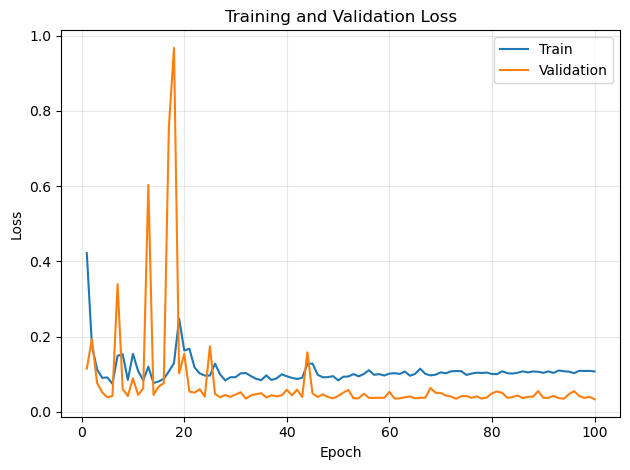

In [7]:
import matplotlib.pyplot as plt

# Lists of 100 floats
train_losses = history['train_loss']
val_losses = history['val_loss']

# Epochs 1..100
epochs = range(1, EPOCHS+1)

plt.figure()
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# test_dataloader = DataLoader(
#     test_dataset, 
#     batch_size=10,
#     collate_fn=collate_pad,
#     shuffle=False,
#     num_workers=0
# )

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# encoder.to(device).eval()
# decoder.to(device).eval()
# test_loss = 0.0
# loss_function = nn.MSELoss(reduction='none')

# with torch.no_grad():
#     for batch in test_dataloader:

#         config = batch[0].to(device)
#         traj = batch[1].to(device)
#         lengths = batch[2].to(device)
        
#         traj = traj.transpose(0,1)
#         ts = traj.shape[0]
#         batch_size = traj.shape[1]

#         mask = (torch.arange(ts, device=device).unsqueeze(1) < lengths.unsqueeze(0)).float() 

#         hidden = encoder(config)
#         decoder_input = torch.zeros(batch_size, 7).to(device)
#         decoder_hidden = hidden
#         predictions = torch.zeros(ts, batch_size, 7).to(device)

#         for t in range(ts):
#             decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
#             predictions[t] = decoder_output
#             decoder_input = decoder_output

#         per_elem = loss_function(predictions, traj)
#         per_step = per_elem.mean(-1)

#         loss = (per_step * mask).sum() / mask.sum().clamp_min(1)
#         test_loss += loss.item()

# avg_test_loss = test_loss / max(len(test_dataloader), 1)
# print(f"Test loss (masked MSE, free-running): {avg_test_loss:.6f}")